#### 1. Метод kNN.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier, KernelDensity
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, roc_curve, auc, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import KFold

Функция для построения ROC-кривой и вычисления AUC.

In [2]:
def plot_roc_curve(y_true, y_scores, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Построение ROC-кривой
    plt.figure(figsize=(8, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.show()

Разметка данных.

In [3]:
df = pd.read_csv('updated_gt_2015.csv')

# Разделение данных на признаки (X) и целевую переменную (y)
X = df[['CO', 'NOX']]
y = df['Class']

In [4]:
# Нормировка данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на тренировочный и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=22)

A) Без весов.

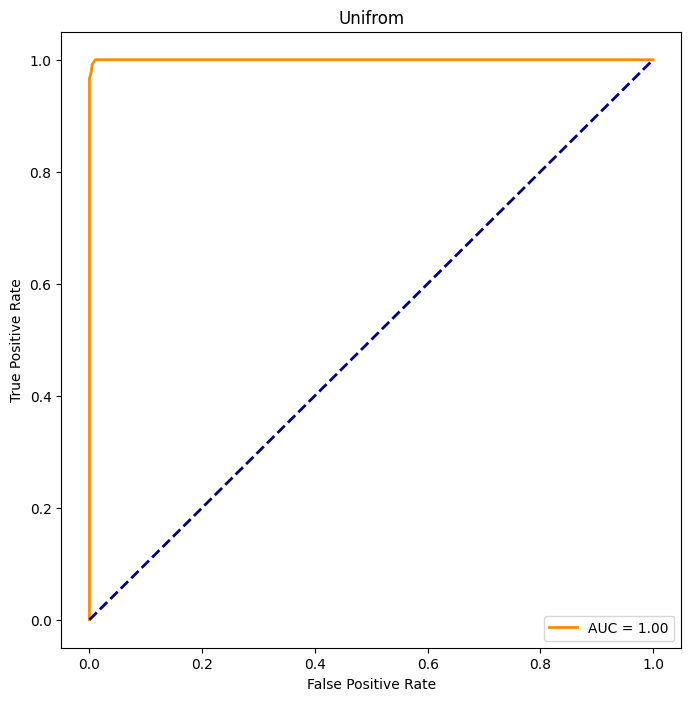

Metrics for 'uniform' weights:
Accuracy: 0.9939
Precision: 0.9829
Recall: 0.9787
F1 Score: 0.9808
F2 Score: 0.9796
Confusion Matrix:
[[1238    4]
 [   5  230]]


In [5]:
# Создание KNN модели с k=5 и метрикой
knn_uniform = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute')

# Обучение моделей
knn_uniform.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred_uniform = knn_uniform.predict(X_test)

# Предсказание вероятностей положительного класса
y_scores_uniform = knn_uniform.predict_proba(X_test)[:, 1]

# Построение ROC-кривой и вычисление AUC-ROC
plot_roc_curve(y_test, y_scores_uniform, 'Unifrom')

# Метрики оценки производительности
print("Metrics for 'uniform' weights:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_uniform):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_uniform):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_uniform):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_uniform):.4f}")
print(f"F2 Score: {fbeta_score(y_test, y_pred_uniform, beta=2):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_uniform))

Б) С весами.

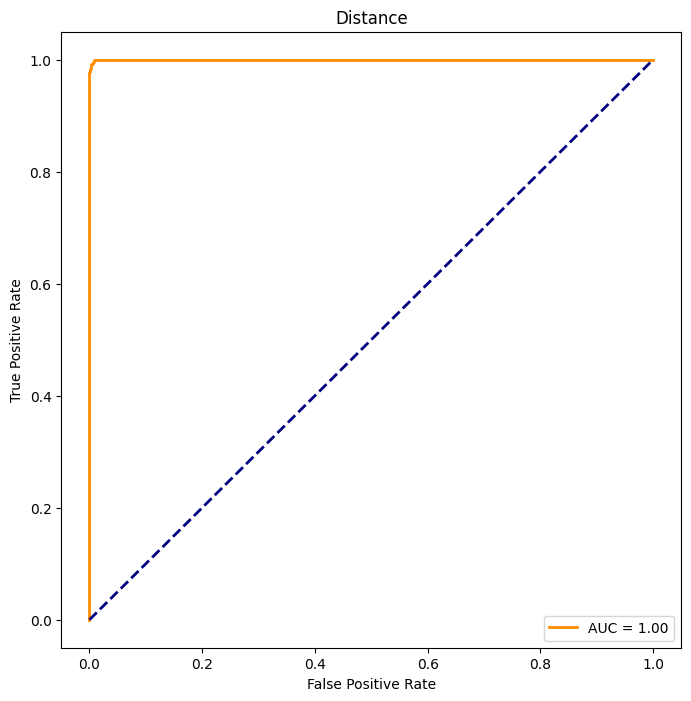

Metrics for 'distance' weights:
Accuracy: 0.9953
Precision: 0.9831
Recall: 0.9872
F1 Score: 0.9851
F2 Score: 0.9864
Confusion Matrix:
[[1238    4]
 [   3  232]]


In [6]:
knn_distance = KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='brute')

knn_distance.fit(X_train, y_train)

y_pred_distance = knn_distance.predict(X_test)

# Предсказание вероятностей положительного класса
y_scores_distance = knn_distance.predict_proba(X_test)[:, 1]

# Построение ROC-кривой и вычисление AUC-ROC
plot_roc_curve(y_test, y_scores_distance, 'Distance')

print("Metrics for 'distance' weights:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_distance):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_distance):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_distance):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_distance):.4f}")
print(f"F2 Score: {fbeta_score(y_test, y_pred_distance, beta=2):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_distance))

#### 2. Метод Leave-One-Out

In [12]:
f2_scorer = make_scorer(fbeta_score, beta=2)
kf = KFold(n_splits=2, shuffle = True, random_state = 22)
for i, (train_index, test_index) in enumerate(kf.split(X_scaled)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")

model = KNeighborsClassifier(weights='distance')
parameters = {'weights':('uniform', 'distance'), 'n_neighbors' : [3,5,7,9]}
clf = GridSearchCV(model, parameters, scoring = f2_scorer, cv = 10)
y_co_np = y.to_numpy().ravel()
clf.fit(X_scaled, y_co_np)

Fold 0:
  Train: index=[   3    6    8 ... 7372 7375 7377]
  Test:  index=[   0    1    2 ... 7381 7382 7383]
Fold 1:
  Train: index=[   0    1    2 ... 7381 7382 7383]
  Test:  index=[   3    6    8 ... 7372 7375 7377]


GridSearchCV(cv=10, estimator=KNeighborsClassifier(weights='distance'),
             param_grid={'n_neighbors': [3, 5, 7, 9],
                         'weights': ('uniform', 'distance')},
             scoring=make_scorer(fbeta_score, beta=2))

In [13]:
print(clf.cv_results_['params'])  # Параметры для каждой модели
print(clf.cv_results_['mean_test_score'])  # Среднее значение F-меры на тестовых данных
print(clf.cv_results_['rank_test_score'])  # Ранг (позиция) каждой комбинации параметров

[{'n_neighbors': 3, 'weights': 'uniform'}, {'n_neighbors': 3, 'weights': 'distance'}, {'n_neighbors': 5, 'weights': 'uniform'}, {'n_neighbors': 5, 'weights': 'distance'}, {'n_neighbors': 7, 'weights': 'uniform'}, {'n_neighbors': 7, 'weights': 'distance'}, {'n_neighbors': 9, 'weights': 'uniform'}, {'n_neighbors': 9, 'weights': 'distance'}]
[0.98730874 0.989549   0.98454973 0.98712268 0.98542047 0.98851403
 0.98159964 0.98694284]
[3 1 7 4 6 2 8 5]


In [9]:
clf.best_score_, clf.best_estimator_, clf.best_params_

(0.9895490013572645,
 KNeighborsClassifier(n_neighbors=3, weights='distance'),
 {'n_neighbors': 3, 'weights': 'distance'})

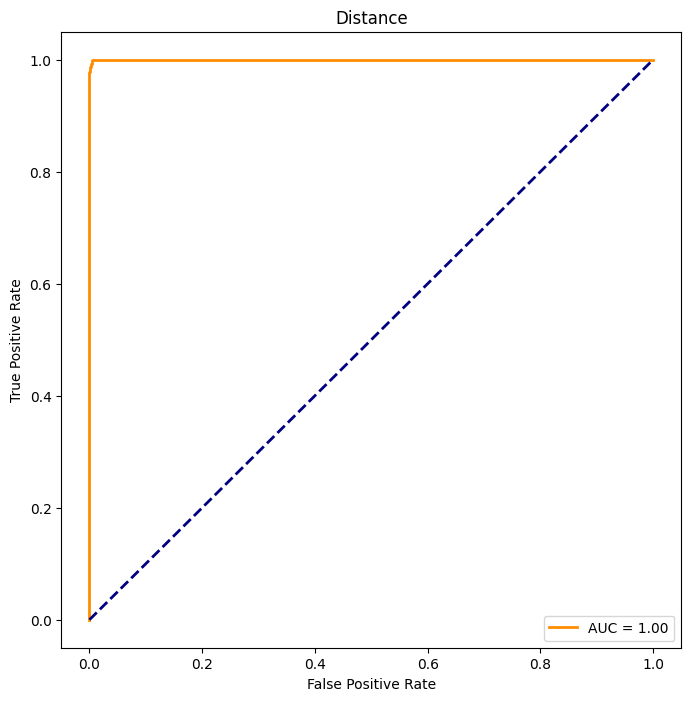

Metrics for 'distance' weights:
Accuracy: 0.9973
Precision: 0.9957
Recall: 0.9872
F1 Score: 0.9915
F2 Score: 0.9889
Confusion Matrix:
[[1241    1]
 [   3  232]]


In [14]:
best_model = KNeighborsClassifier(weights=clf.best_params_['weights'],  
                                  n_neighbors=clf.best_params_['n_neighbors'],
                                  )

best_model.fit(X_train, y_train)

y_pred_distance = best_model.predict(X_test)

# Предсказание вероятностей положительного класса
y_scores_distance = best_model.predict_proba(X_test)[:, 1]

# Построение ROC-кривой и вычисление AUC-ROC
plot_roc_curve(y_test, y_scores_distance, 'Distance')

print("Metrics for 'distance' weights:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_distance):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_distance):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_distance):.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred_distance):.4f}")
print(f"F2 Score: {fbeta_score(y_test, y_pred_distance, beta=2):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_distance))